# Stable Baselines3 튜토리얼 - Wrappers

이 튜토리얼은 Stable Baselins3 라이브러리의 공식 튜토리얼과 예제 코드를 참고/번역하여 작성되었습니다.

출처 : [https://github.com/Stable-Baselines-Team/rl-colab-notebooks](https://github.com/Stable-Baselines-Team/rl-colab-notebooks)

Stable-Baselines3 Github: https://github.com/DLR-RM/stable-baselines3

공식 문서: https://stable-baselines.readthedocs.io/en/master/



## Wrapper class란?

일반적으로 wrapper class는 기존 클래스를 감싸는 클래스를 의미합니다. 이를 통해 기존 클래스의 기능을 확장하거나 변경할 수 있습니다.

Gymnasium 환경을 사용할 때, wrapper class를 사용하여 환경을 수정하거나 확장할 수 있습니다. 이를 통해 다양한 목적으로 환경을 수정할 수 있습니다.

Stable Baselines3에서는 강화학습 모델 훈련을 위해 미리 정의된 wrapper class를 제공합니다.

이 튜토리얼에서는 대표적인 wrapper class들의 사용법을 살펴보겠습니다.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

## 1. Monitor

`Monitor`는 reward, episode 길이등의 통계 정보를 기록하는 wrapper입니다.

훈련과정에서 logging과 agent의 성능을 평가하는데 유용합니다.

In [2]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

env = gym.make('CartPole-v1')

file_name = "tmp/monitor_log"

# Wrap the environment with Monitor to log statistics
env = Monitor(env, filename=file_name)

# Create the PPO model (PPO is a popular algorithm)
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
print("Training the model...")
model.learn(total_timesteps=50_000)

Using cpu device
Wrapping the env in a DummyVecEnv.
Training the model...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 20.8     |
| time/              |          |
|    fps             | 6034     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26          |
|    ep_rew_mean          | 26          |
| time/                   |             |
|    fps                  | 3767        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008282583 |
|    clip_fraction        | 0.0814      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      

In [3]:
# Load the monitor logs (rewards and episode lengths)
monitor_data = []
with open(f"{file_name}.monitor.csv", "r") as file:
    # Skip the header
    next(file)
    next(file)
    for line in file:
        # Parse the CSV values (episode length, total reward, ...)
        values = line.split(',')
        # print(values)
        total_reward = float(values[0])
        episode_length = int(values[1])
        monitor_data.append((episode_length, total_reward))

# Separate episode lengths and rewards for plotting
episode_lengths, rewards = zip(*monitor_data)

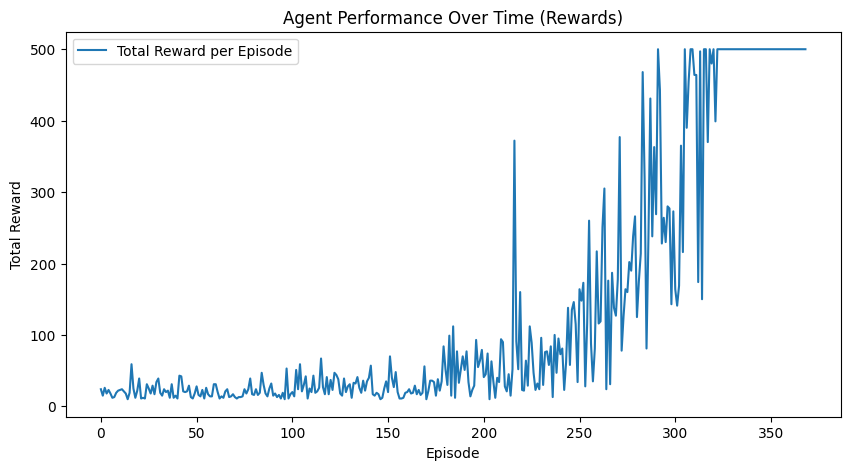

In [4]:
# Plot the rewards over episodes
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Agent Performance Over Time (Rewards)")
plt.legend()
plt.show()

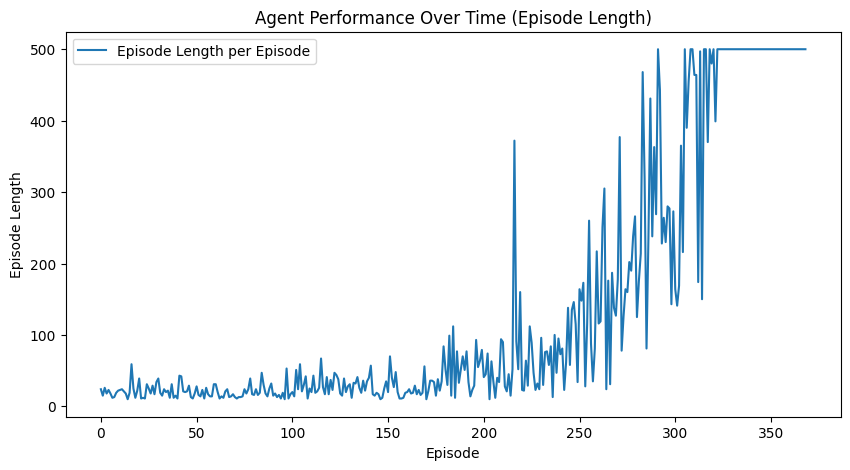

In [5]:
# Plot the episode lengths over episodes
plt.figure(figsize=(10, 5))
plt.plot(episode_lengths, label="Episode Length per Episode")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.title("Agent Performance Over Time (Episode Length)")
plt.legend()
plt.show()

## 2. VecEnv

VecEnv wrapper는 여러 환경을 병렬로 실행할 수 있도록 해줍니다.

- `DummyVecEnv`: VecEnv이지만 순차적으로 실행됩니다.
  - 멀티프로세스나 멀티스레드의 오버헤드가 환경 계산 시간보다 클 때 유용합니다.
  - 또한 VecEnv가 필요한 알고리즘을 단일 환경에서 훈련하고자 할 때도 사용할 수 있습니다.
- `SubprocVecEnv`: 개별 환경을 각 프로세스에 분배하여 병렬로 실행합니다.
  - 환경이 계산적으로 복잡할 때 상당한 속도 향상을 제공합니다.

In [6]:
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

# DummyVecEnv example
env = DummyVecEnv([lambda: gym.make('CartPole-v1') for _ in range(4)])

# SubprocVecEnv example
env = SubprocVecEnv([lambda: gym.make('CartPole-v1') for _ in range(4)])

## 3. FrameStack

`VecFrameStack`은 연속적인 observation frame을 쌓아서 agent에게 전달합니다.
- 주로 이미지 기반의 환경에서 사용됩니다. (Atari, VizDoom 등)
- 한 frame만 사용하는 것보다 여러 frame을 사용하면 agent가 움직임을 인식하는데 도움이 됩니다.

In [7]:
from stable_baselines3.common.vec_env import VecFrameStack
env = VecFrameStack(env, n_stack=4)  # Stack 4 frames

## 4. Normalize

`VecNormalize`는 observation과 reward를 normalize합니다.
- observation feature 혹은 reward의 scale의 편차가 클 때 사용합니다.

In [8]:
from stable_baselines3.common.vec_env import VecNormalize

env = VecNormalize(env)

## 5. Action Noise

`ActionNoise`는 agent의 action에 noise를 추가합니다.
- continuous action space에서 사용됩니다.
- DDPG, TD3, SAC 등과 같은 알고리즘에서 exploration을 장려하기 위해 사용됩니다.

### action noise와 함께 훈련

In [9]:
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.evaluation import evaluate_policy

# continuous action space 환경 (Pendulum-v1) 생성
env = gym.make('Pendulum-v1')

# n_actions 정의 (Pendulum-v1의 action space는 shape이 (1,)이므로 n_actions=1)
n_actions = env.action_space.shape[-1]

# NormalActionNoise 객체 생성 (평균이 0이고, 표준편차가 0.1인 정규분포로부터 생성된 action noise)
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# action noise가 추가된 DDPG 모델 생성
model_with_noise = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=0)

# 훈련
print("Training model WITH noise...")
model_with_noise.learn(total_timesteps=50_000)

# 평가
mean_reward_with_noise, _ = evaluate_policy(model_with_noise, env, n_eval_episodes=10)


Training model WITH noise...


/Users/chiyeong/Documents/projects/Mentoring-RL-Env/.venv/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


### action noise 없이 훈련

In [10]:
# action noise가 없는 DDPG 모델 생성
model_without_noise = DDPG("MlpPolicy", env, verbose=0)

# 훈련
print("Training model WITHOUT noise...")
model_without_noise.learn(total_timesteps=50_000)

# 평가
mean_reward_without_noise, _ = evaluate_policy(model_without_noise, env, n_eval_episodes=10)    

Training model WITHOUT noise...


In [11]:
# 결과 비교
print(f"Mean reward WITH noise: {mean_reward_with_noise}")
print(f"Mean reward WITHOUT noise: {mean_reward_without_noise}")


Mean reward WITH noise: -134.52429618593305
Mean reward WITHOUT noise: -168.52268375941784
